#### Select the model weight .pth file ####

In [1]:
import torch
from DCUnet import DCUnet10, DCUnet10_cTSTM, DCUnet10_rTSTM
import torchaudio
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from metrics import AudioMetrics
import numpy as np
from matplotlib import colors, pyplot as plt

/home/maoyj/projects/MIA-SE/Chapter4/IDDP/metrics_utils.py:59: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def lpcoeff(speech_frame, model_order):


In [3]:
# First checking if GPU is available
train_on_gpu = torch.cuda.is_available()
if (train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')
DEVICE = torch.device('cuda:3' if train_on_gpu else 'cpu')

# If running on Cuda set these 2 for determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set Audio backend as Soundfile for windows and Sox for Linux
torchaudio.set_audio_backend("sox_io")
print("TorchAudio backend used:\t{}".format(torchaudio.get_audio_backend()))


###################################### Parameters of Speech processing ##################################
SAMPLE_RATE = 48000
N_FFT = (SAMPLE_RATE * 64) // 1000 
HOP_LENGTH = (SAMPLE_RATE * 16) // 1000 

Training on GPU.
TorchAudio backend used:	sox_io


In [4]:
# Spectrogram plotting function
def plot_spectrogram(signal, title, output_dir, fs=SAMPLE_RATE, figsize=(6, 5), ylim=None):
    plt.figure(figsize=figsize)
    plt.specgram(signal, Fs=SAMPLE_RATE, NFFT=N_FFT, noverlap=HOP_LENGTH, cmap='viridis')   #红黑：inferno   蓝绿：viridis
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    if ylim:
        plt.ylim(ylim)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.savefig(output_dir + title.replace(' ', '_') + '.png')  # Save the spectrogram as an image
    plt.show()


# Waveform plotting function
def plot_waveform(signal, title, output_dir, fs=SAMPLE_RATE, figsize=(6, 5)):
    time_axis = np.linspace(0, len(signal) / fs, num=len(signal))
    plt.figure(figsize=figsize)
    plt.plot(time_axis, signal, color=(237/255, 125/255, 49/255))
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.savefig(output_dir + title.replace(' ', '_') + '.png')  # Save the waveform as an image
    plt.show()

In [5]:

model_weights_path = "/home/maoyj/projects/MIA-SE/Chapter4/checkpoints/US1/IDDP_dc10_model_62.pth"

dcunet20 = DCUnet10_cTSTM(N_FFT, HOP_LENGTH, DEVICE).to(DEVICE)
optimizer = torch.optim.Adam(dcunet20.parameters())

checkpoint = torch.load(model_weights_path)

RuntimeError: CUDA error: out of memory

In [ ]:
dcunet20.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
def get_data (file):
    waveform, _ = torchaudio.load(file)
    waveform = waveform.numpy()
    current_len = waveform.shape[1]
        
    output = np.zeros((1, 165000), dtype='float32')
    output[0, -current_len:] = waveform[0, :165000]
    output = torch.from_numpy(output)
    return output, current_len

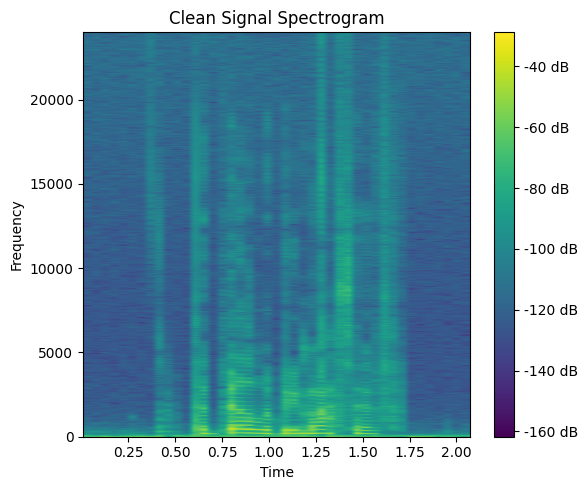

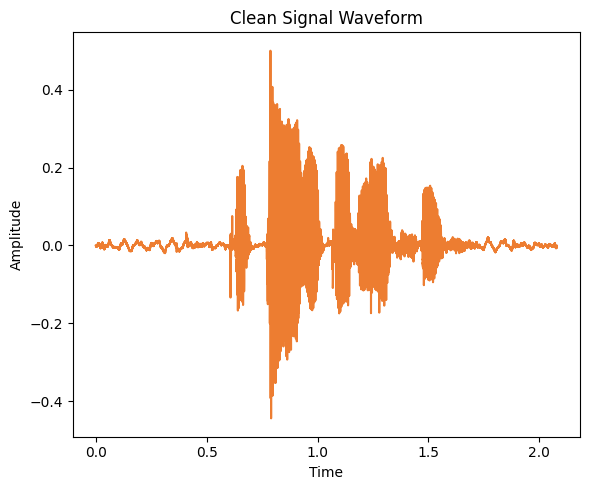

In [10]:
clean_file = "/home/maoyj/projects/MIA-SE/Noise2Noise-audio_denoising_without_clean_training_data/Datasets_US/Voice_Demand/clean_testset_wav/p257_434.wav"
clean, _ = torchaudio.load(clean_file)
x_clean_stft = torch.stft(input=clean, n_fft=N_FFT, 
                          hop_length=HOP_LENGTH, normalized=True)
x_clean_stft = x_clean_stft.unsqueeze(0)
x_c_np = torch.istft(torch.squeeze(x_clean_stft[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()
output_dir = "/home/maoyj/projects/MIA-SE/Chapter4/Experiment/VD/p257_434_"

plot_spectrogram(x_c_np, 'Clean Signal Spectrogram', output_dir)
plot_waveform(x_c_np, 'Clean Signal Waveform', output_dir)


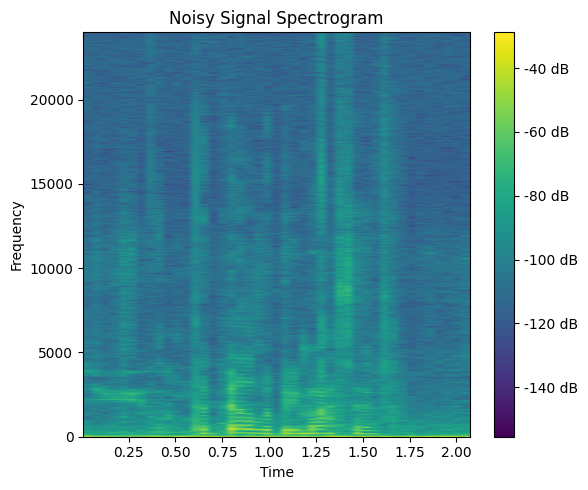

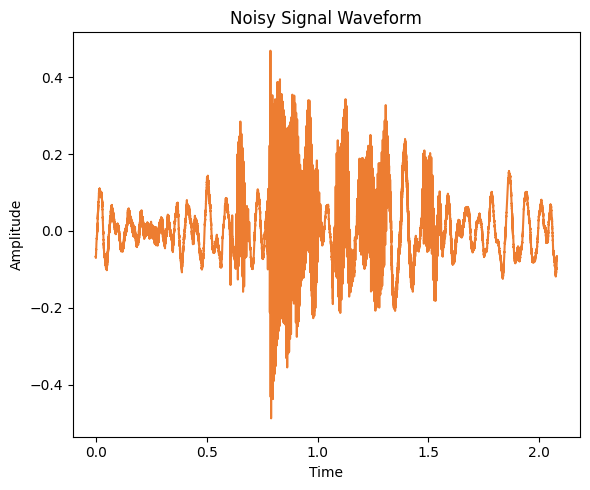

In [11]:
noisy_file = "/home/maoyj/projects/MIA-SE/Noise2Noise-audio_denoising_without_clean_training_data/Datasets_US/Voice_Demand/noisy_testset_wav/p257_434.wav"
# output_dir = "/home/maoyj/projects/MIA-SE/Chapter3/SL-DCUnet-TSTM/samples/real_"
noisy, _ = torchaudio.load(noisy_file)
# noisy, current_len = get_data(noisy_file)
x_noisy_stft = torch.stft(input=noisy, n_fft=N_FFT, 
                          hop_length=HOP_LENGTH, normalized=True)
x_noisy_stft = x_noisy_stft.unsqueeze(0)
x_n_np = torch.istft(torch.squeeze(x_noisy_stft[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()
plot_spectrogram(x_n_np, 'Noisy Signal Spectrogram', output_dir)
plot_waveform(x_n_np, 'Noisy Signal Waveform', output_dir)

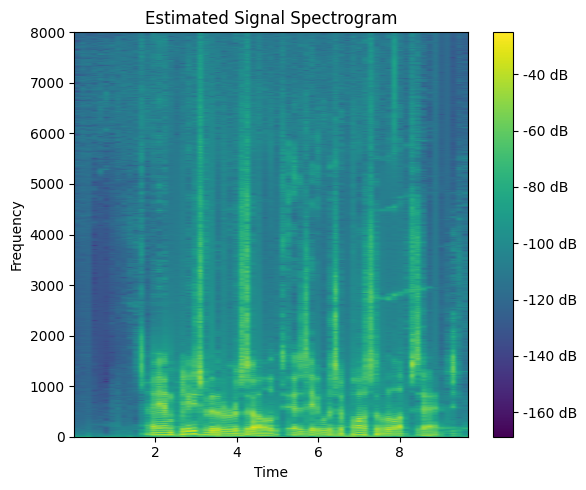

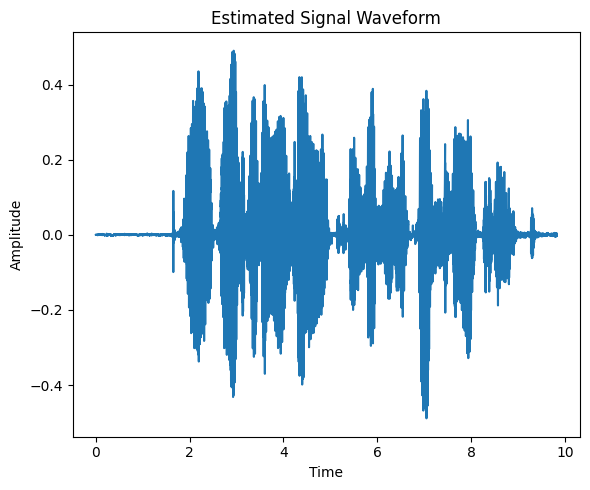

In [43]:
noisy_file = "/home/maoyj/projects/MIA-SE/Noise2Noise-audio_denoising_without_clean_training_data/Datasets_US/Voice_Demand/noisy_testset_wav/p232_066.wav"
noisy, current_len = get_data(noisy_file)
x_noisy_stft = torch.stft(input=noisy, n_fft=N_FFT, 
                          hop_length=HOP_LENGTH, normalized=True)
x_noisy_stft = x_noisy_stft.unsqueeze(0)

x_est = dcunet20(x_noisy_stft.to(DEVICE), N_FFT, HOP_LENGTH, DEVICE, is_istft=True)
x_est_np = x_est[0].view(-1).detach().cpu().numpy()
plot_spectrogram(x_est_np[-current_len:], 'Estimated Signal Spectrogram', output_dir)
plot_waveform(x_est_np[-current_len:], 'Estimated Signal Waveform', output_dir)
# plot_spectrogram(x_est_np[-current_len:], 'Estimated Signal Spectrogram', output_dir)
# plot_waveform(x_est_np[-current_len:], 'Estimated Signal Waveform', output_dir)

In [44]:
import soundfile as sf
sf.write(output_dir + 'output.wav', x_est_np, SAMPLE_RATE)

In [18]:
# 测试单一音频
clean_file = "/home/maoyj/projects/MIA-SE/Chapter3/Voice_Demand_16/clean_testset_wav/p257_434.wav"
noisy_file = "/home/maoyj/projects/MIA-SE/Chapter3/Voice_Demand_16/noisy_testset_wav/p257_434.wav"
noisy, _ = get_data(noisy_file)
clean, _ = get_data(clean_file)
x_noisy_stft = torch.stft(input=noisy, n_fft=N_FFT, 
                          hop_length=HOP_LENGTH, normalized=True)
x_noisy_stft = x_noisy_stft.unsqueeze(0)

x_clean_stft = torch.stft(input=clean, n_fft=N_FFT, 
                          hop_length=HOP_LENGTH, normalized=True)
x_clean_stft = x_clean_stft.unsqueeze(0)

x_est = dcunet20(x_noisy_stft.to(DEVICE), N_FFT, HOP_LENGTH, DEVICE, is_istft=True)
# 时频图函数

x_n_np = torch.istft(torch.squeeze(x_noisy_stft[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()
x_c_np = torch.istft(torch.squeeze(x_clean_stft[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()
# 对于每个信号画出时频图
x_est_np = x_est[0].view(-1).detach().cpu().numpy()
# plot_spectrogram(x_est_np, 'Estimated Signal Spectrogram', output_dir)

d0: torch.Size([1, 32, 256, 107, 2])
d1: torch.Size([1, 64, 127, 53, 2])
d2: torch.Size([1, 64, 63, 26, 2])
d3: torch.Size([1, 64, 31, 12, 2])
d4: torch.Size([1, 64, 15, 10, 2])
out: torch.Size([1, 64, 15, 10, 2])
u0: torch.Size([1, 64, 31, 12, 2])
c0: torch.Size([1, 128, 31, 12, 2])
u1: torch.Size([1, 64, 63, 26, 2])
c1: torch.Size([1, 128, 63, 26, 2])
u2: torch.Size([1, 64, 127, 53, 2])
c2: torch.Size([1, 128, 127, 53, 2])
u3: torch.Size([1, 32, 256, 107, 2])
c3: torch.Size([1, 64, 256, 107, 2])
u4: torch.Size([1, 1, 513, 215, 2])


In [19]:
metrics = AudioMetrics(x_c_np, x_n_np, SAMPLE_RATE)
print(metrics.display())

CSIG : 4.045
CBAK : 3.241
COVL : 3.216
PESQ : 2.417
SSNR : -6.619
STOI : 0.555
SNR : 0.295
None


In [20]:
metrics = AudioMetrics(x_c_np, x_est_np, SAMPLE_RATE)
print(metrics.display())

CSIG : 4.029
CBAK : 3.798
COVL : 3.300
PESQ : 2.545
SSNR : 0.061
STOI : 0.590
SNR : 17.957
None


# 真实样本测试

In [141]:

model_weights_path = "/home/maoyj/projects/MIA-SE/Chapter4/checkpoints/white/IDDP_dc20_model_15.pth"

dcunet20 = DCUnet10_cTSTM(N_FFT, HOP_LENGTH, DEVICE).to(DEVICE)
optimizer = torch.optim.Adam(dcunet20.parameters())

checkpoint = torch.load(model_weights_path)

dcunet20.load_state_dict(checkpoint)

<All keys matched successfully>

In [114]:
# Spectrogram plotting function
def plot_spectrogram(signal, title, output_dir, fs, n_fft, hop_length, figsize=(6, 5), ylim=None):
    plt.figure(figsize=figsize)
    plt.specgram(signal, Fs=fs, NFFT=n_fft, noverlap=hop_length, cmap='inferno')   #蓝绿：viridis
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    if ylim:
        plt.ylim(ylim)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.savefig(output_dir + title.replace(' ', '_') + '.png')  # Save the spectrogram as an image
    plt.show()




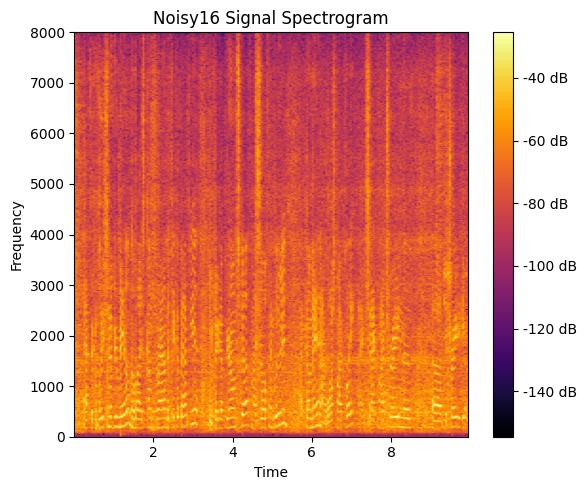

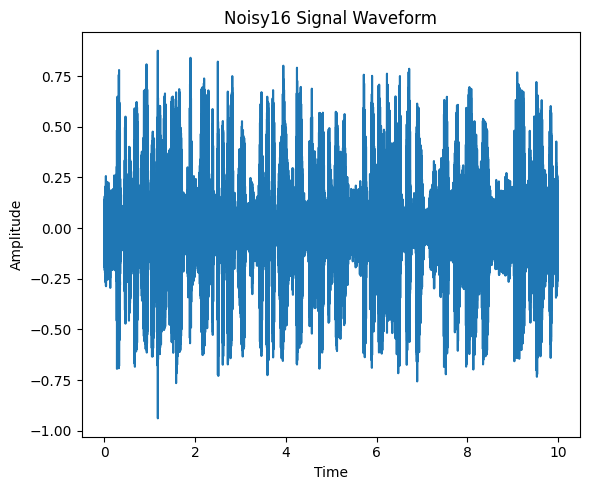

In [115]:
noisy_file = "/home/maoyj/projects/MIA-SE/Chapter4/Samples/1/real_noisy.mp3"
output_dir = "/home/maoyj/projects/MIA-SE/Chapter4/Samples/1/real_"
noisy, orig_sr = torchaudio.load(noisy_file)
# noisy, current_len = get_data(noisy_file)
x_noisy_stft = torch.stft(input=noisy, n_fft=N_FFT, 
                          hop_length=HOP_LENGTH, normalized=True)
x_noisy_stft = x_noisy_stft.unsqueeze(0)
x_n_np = torch.istft(torch.squeeze(x_noisy_stft[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()
plot_spectrogram(x_n_np, 'Noisy16 Signal Spectrogram', output_dir, fs=16000, n_fft=1024, hop_length=256)
plot_waveform(x_n_np, 'Noisy16 Signal Waveform', output_dir)

In [116]:
def get_data (file):
    waveform, orig_sr = torchaudio.load(file)
    # 设定目标采样率
    target_sr = 48000
    # 进行重采样
    resample_transform = Resample(orig_sr, target_sr)
    resampled = resample_transform(waveform)
    
    resampled = resampled.numpy()
    current_len = resampled.shape[1]
    
    output = np.zeros((1, 165000), dtype='float32')
    output[0, -current_len:] = resampled[0, :165000]
    output = torch.from_numpy(output)
    return output, current_len

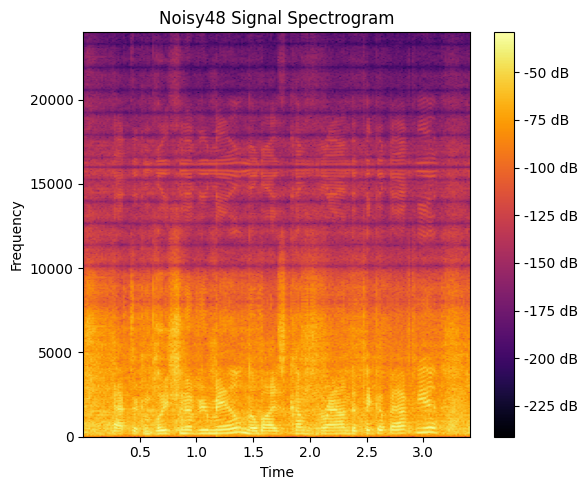

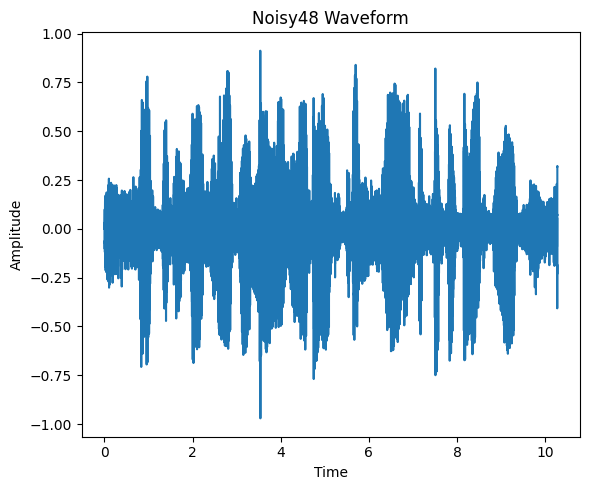

In [117]:
import torchaudio
from torchaudio.transforms import Resample

noisy_file = "/home/maoyj/projects/MIA-SE/Chapter4/Samples/1/real_noisy.mp3"

# 加载音频文件并获取其采样率
# noisy, orig_sr = torchaudio.load(noisy_file)
noisy, current_len = get_data(noisy_file)
# # 设定目标采样率
# target_sr = 48000

# # 进行重采样
# resample_transform = Resample(orig_sr, target_sr)
# noisy_resampled = resample_transform(noisy)

# 计算STFT
x_noisy_stft = torch.stft(input=noisy, n_fft=N_FFT, 
                          hop_length=HOP_LENGTH, normalized=True)
x_noisy_stft = x_noisy_stft.unsqueeze(0)

# 进行ISTFT以获取时域信号
x_n_np = torch.istft(torch.squeeze(x_noisy_stft[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()

# 绘制语谱图和波形图，这里假设plot_spectrogram和plot_waveform函数已经定义
plot_spectrogram(x_n_np, 'Noisy48 Signal Spectrogram', output_dir, fs=48000, n_fft=1024, hop_length=256)
plot_waveform(x_n_np, 'Noisy48 Waveform', output_dir)




In [118]:
sf.write(output_dir + 'noisy48.wav', x_n_np, SAMPLE_RATE)

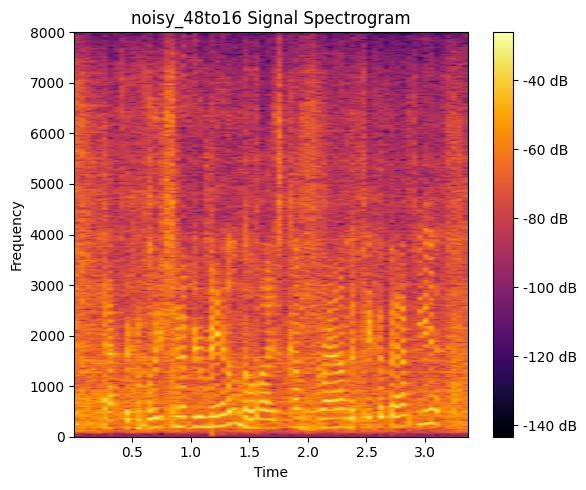

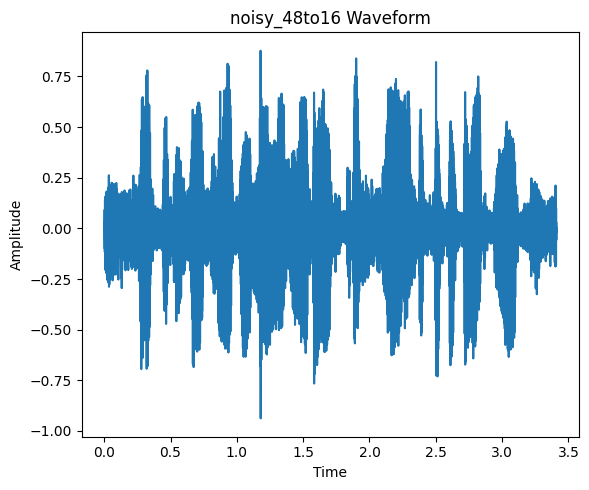

In [127]:
noisy_file = "/home/maoyj/projects/MIA-SE/Chapter4/Samples/1/IPTT_US1/real_noisy48.wav"
# 加载音频文件并获取其采样率
noisy, orig_sr = torchaudio.load(noisy_file)
# noisy, current_len = get_data(noisy_file)
# 设定目标采样率
target_sr = 16000

# 进行重采样
resample_transform = Resample(orig_sr, target_sr)
noisy_resampled = resample_transform(noisy)

# 计算STFT
x_noisy_stft = torch.stft(input=noisy_resampled, n_fft=N_FFT, 
                          hop_length=HOP_LENGTH, normalized=True)
x_noisy_stft = x_noisy_stft.unsqueeze(0)

# 进行ISTFT以获取时域信号
x_n_np = torch.istft(torch.squeeze(x_noisy_stft[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()

# 绘制语谱图和波形图，这里假设plot_spectrogram和plot_waveform函数已经定义
plot_spectrogram(x_n_np, 'noisy_48to16 Signal Spectrogram', output_dir, fs=16000, n_fft=1024, hop_length=256)
plot_waveform(x_n_np, 'noisy_48to16 Waveform', output_dir)


In [128]:
sf.write(output_dir + 'noisy48to16.wav', x_n_np, 16000)

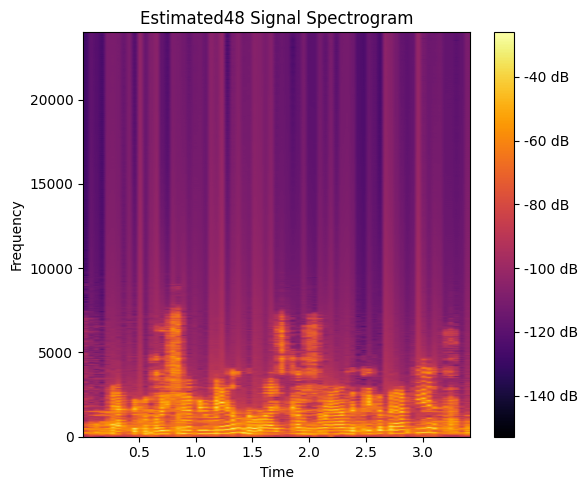

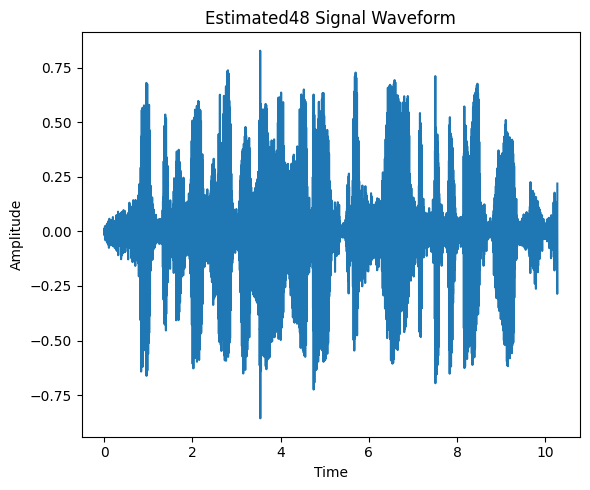

In [142]:
noisy_file = "/home/maoyj/projects/MIA-SE/Chapter4/Samples/1/real_noisy.mp3"
noisy, current_len = get_data(noisy_file)
x_noisy_stft = torch.stft(input=noisy, n_fft=N_FFT, 
                          hop_length=HOP_LENGTH, normalized=True)
x_noisy_stft = x_noisy_stft.unsqueeze(0)

x_est = dcunet20(x_noisy_stft.to(DEVICE), N_FFT, HOP_LENGTH, DEVICE, is_istft=True)
x_est_np = x_est[0].view(-1).detach().cpu().numpy()

plot_spectrogram(x_est_np[-current_len:], 'Estimated48 Signal Spectrogram', output_dir, fs=48000, n_fft=N_FFT, hop_length=HOP_LENGTH)
plot_waveform(x_est_np[-current_len:], 'Estimated48 Signal Waveform', output_dir)



In [143]:
import soundfile as sf
sf.write(output_dir + 'output48.wav', x_est_np, 48000)

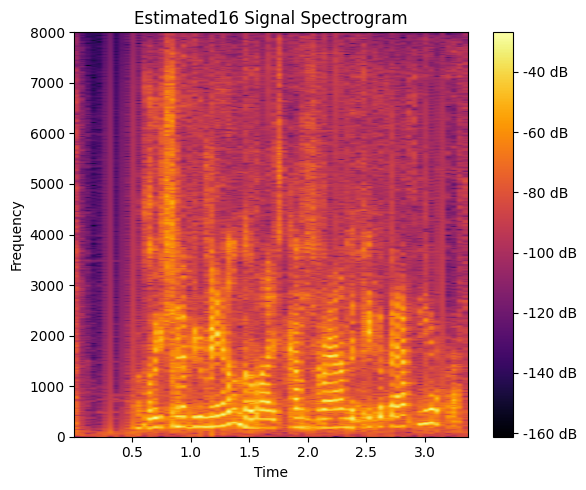

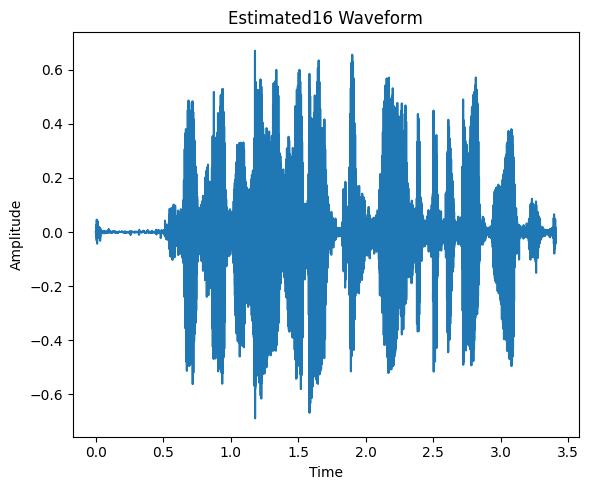

In [136]:
noisy_file = "/home/maoyj/projects/MIA-SE/Chapter4/Samples/1/real_output48.wav"
# 加载音频文件并获取其采样率
noisy, orig_sr = torchaudio.load(noisy_file)
# noisy, current_len = get_data(noisy_file)
# 设定目标采样率
target_sr = 16000

# 进行重采样
resample_transform = Resample(orig_sr, target_sr)
noisy_resampled = resample_transform(noisy)

# 计算STFT
x_noisy_stft = torch.stft(input=noisy_resampled, n_fft=N_FFT, 
                          hop_length=HOP_LENGTH, normalized=True)
x_noisy_stft = x_noisy_stft.unsqueeze(0)

# 进行ISTFT以获取时域信号
x_n_np = torch.istft(torch.squeeze(x_noisy_stft[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()

# 绘制语谱图和波形图，这里假设plot_spectrogram和plot_waveform函数已经定义
plot_spectrogram(x_n_np, 'Estimated16 Signal Spectrogram', output_dir, fs=16000, n_fft=1024, hop_length=256)
plot_waveform(x_n_np, 'Estimated16 Waveform', output_dir)

In [137]:
sf.write(output_dir + 'output16.wav', x_n_np, 16000)

In [91]:
# Spectrogram plotting function
def plot_spectrogram(signal, title, output_dir, fs=target_sr, figsize=(6, 5), ylim=None):
    plt.figure(figsize=figsize)
    plt.specgram(signal, Fs=fs, NFFT=512, noverlap=128, cmap='inferno')   #蓝绿：viridis
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    if ylim:
        plt.ylim(ylim)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.savefig(output_dir + title.replace(' ', '_') + '.png')  # Save the spectrogram as an image
    plt.show()


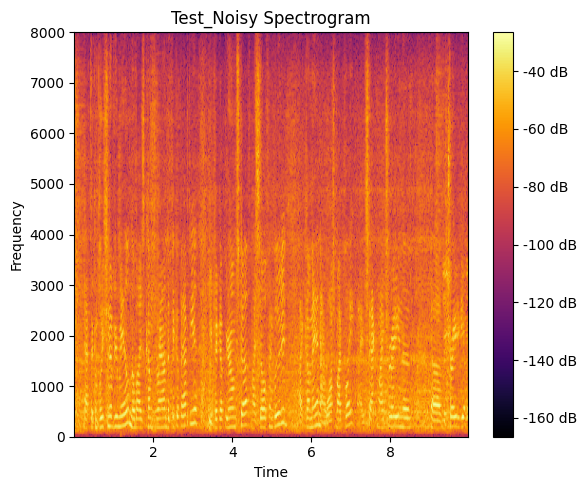

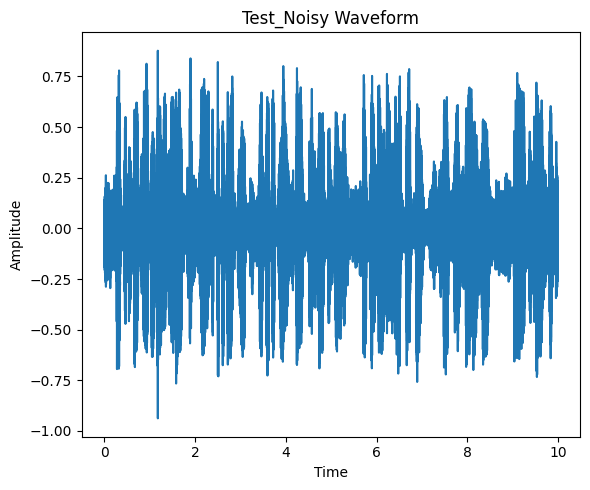

In [92]:
noisy_file = "/home/maoyj/projects/MIA-SE/Chapter4/Samples/1/real_noisy48.wav"

# 加载音频文件并获取其采样率
noisy, orig_sr = torchaudio.load(noisy_file)

# 设定目标采样率
target_sr = 16000

# 进行重采样
resample_transform = Resample(orig_sr, target_sr)
noisy_resampled = resample_transform(noisy)

# 计算STFT
x_noisy_stft = torch.stft(input=noisy_resampled, n_fft=N_FFT, 
                          hop_length=HOP_LENGTH, normalized=True)
x_noisy_stft = x_noisy_stft.unsqueeze(0)

# 进行ISTFT以获取时域信号
x_n_np = torch.istft(torch.squeeze(x_noisy_stft[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()

# 绘制语谱图和波形图，这里假设plot_spectrogram和plot_waveform函数已经定义
plot_spectrogram(x_n_np, 'Test_Noisy Spectrogram',  output_dir, fs=target_sr)
plot_waveform(x_n_np, 'Test_Noisy Waveform', output_dir)